# 8 Integration with pandas

> Objectives:
> * Use pandas.HDFStore for serializing/deserializing pandas dataframes in HDF5 files
> * Compare in-memory queries (via pandas dataframes) with on-disk ones (via HDFStore)
> * Apply this to visualizing pokemons in Barcelona, New York and more!

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import shutil

matplotlib.rcParams.update({'font.size': 12})

In [4]:
data_dir = "hdfstore"
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
os.mkdir(data_dir)

# pandas.HDFStore()

A pandas DataFrame is a two-dimensional datacontainer. Columns are labeled. DataFrame resemble `numpy.recarray` with a focus on features. DataFrames support slicing, selections, merge's etc.

In [4]:
df = pd.DataFrame(np.random.randn(15, 3), columns=['A', 'B', 'C'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
A    15 non-null float64
B    15 non-null float64
C    15 non-null float64
dtypes: float64(3)
memory usage: 440.0 bytes


In [6]:
df.head()

A         B         C
0  0.838754 -0.992335 -0.297503
1  0.335792 -0.977752  0.962278
2  0.190142  0.048889 -0.980975
3  0.280236  0.677323  2.762983
4 -1.254403  0.635598  0.280509

In [7]:
fn = os.path.join(data_dir, 'test.h5')
hdfstore = pd.HDFStore(fn, 'w')

`pandas.HDFStore` acts like a `dict` similar to h5py:

In [8]:
hdfstore['my_array'] = df

In [9]:
print(hdfstore)

<class 'pandas.io.pytables.HDFStore'>
File path: hdfstore\test.h5
/my_array            frame        (shape->[15,3])


By using `HDFStore.put()` we can specify options such as the dataset type, indexing etc.

In [10]:
hdfstore.put('my_table', df[:5], format='table')
hdfstore

<class 'pandas.io.pytables.HDFStore'>
File path: hdfstore\test.h5
/my_array            frame        (shape->[15,3])                                      
/my_table            frame_table  (typ->appendable,nrows->5,ncols->3,indexers->[index])

In [11]:
hdfstore.append('my_table', df[5:])
hdfstore

<class 'pandas.io.pytables.HDFStore'>
File path: hdfstore\test.h5
/my_array            frame        (shape->[15,3])                                       
/my_table            frame_table  (typ->appendable,nrows->15,ncols->3,indexers->[index])

In [12]:
hdfstore.close()

In [13]:
!ptdump -v {fn}

/ (RootGroup) ''
/my_array (Group) ''
/my_array/axis0 (Array(3,)) ''
  atom := StringAtom(itemsize=1, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None
/my_array/axis1 (Array(15,)) ''
  atom := Int64Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/my_array/block0_items (Array(3,)) ''
  atom := StringAtom(itemsize=1, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None
/my_array/block0_values (Array(15, 3)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/my_table (Group) ''
/my_table/table (Table(15,)) ''
  description := {
  "index": Int64Col(shape=(), dflt=0, pos=0),
  "values_block_0": Float64Col(shape=(3,), dflt=0.0, pos=1)}
  byteorder := 'little'
  chunkshape := (2048,)
  autoindex := True
  colindexes := {
    "index": Index(6, medium, shuffle, z

Note that only the index column is indexed.

use `data_columns=[]` to index other columns. Use `data_columns=True` to index all columns.

### to_hdf()
A `pandas.DataFrame` has a `to_hdf()` method, which is similar to:

```
with pd.HDFStore(filename, mode='w') as hdfstore:
   hdfstore.put(...)
```

`to_hdf()` only supports BLOSC additional compressors (`complib='blosc:lz4'`) from pandas v0.20.2 (released June 2017)

In [14]:
tmpfn = os.path.join(data_dir, 'tmp.h5')
df.to_hdf(tmpfn, 'my_table', format='table', mode='w')

In [71]:
!ptdump -v {tmpfn}

/ (RootGroup) ''
/my_table (Group) ''
/my_table/table (Table(15,)) ''
  description := {
  "index": Int64Col(shape=(), dflt=0, pos=0),
  "values_block_0": Float64Col(shape=(3,), dflt=0.0, pos=1)}
  byteorder := 'little'
  chunkshape := (2048,)
  autoindex := True
  colindexes := {
    "index": Index(6, medium, shuffle, zlib(1)).is_csi=False}


### Exercise

Open the hdf5 file with `h5py` or `pytables` and investigate the contents. (Alternative use `h5ls`, `h5dump` and/or `ptdump`)

In [17]:
#
#
# Solution starts here
#
#

In [18]:
import h5py

In [19]:
f = h5py.File(fn)

In [20]:
list(f)

['my_array', 'my_table']

In [21]:
f['my_array/axis0'][:]

array([b'A', b'B', b'C'],
      dtype='|S1')

In [22]:
f['/my_array/block0_values'][:]

array([[ 0.83875448, -0.99233487, -0.29750259],
       [ 0.33579183, -0.97775233,  0.96227759],
       [ 0.19014214,  0.04888886, -0.98097473],
       [ 0.28023634,  0.67732312,  2.76298317],
       [-1.25440259,  0.63559755,  0.28050877],
       [ 0.9377919 ,  1.3000436 ,  0.80803729],
       [ 0.1245721 ,  1.03471468, -0.00670735],
       [-0.77747718,  0.28793536,  0.74051275],
       [ 0.67522361, -0.84288014,  1.04799158],
       [-1.49765891, -0.04403355,  0.37254814],
       [ 0.19855198, -1.26141401, -0.29150516],
       [ 1.5945199 ,  0.61115275,  0.7104898 ],
       [-0.9515245 , -0.9786461 , -0.17991023],
       [ 0.92022387, -0.42064375,  0.08286471],
       [-1.07561516,  2.09769878, -1.09069454]])

In [23]:
f.close()

## Large CSV dataset: Pokemon sightings

Let's see how HDF5 integrates with pandas while we are having fun visualizing the different kinds of pokemons in different geographical areas.  The dataset that we will be using here can obtained from https://www.kaggle.com/semioniy/predictemall.

The zipped version of the dataset (`300k_csv.zip` is about 38Mbytes. The original CSV is about 480Mb).

In [24]:
%%time
df = pd.read_csv('datasets/pokemon/300k_csv.zip')

<string>:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 22.4 s


In [25]:
df[['city','latitude', 'longitude']].head(15)

city   latitude   longitude
0   Mexico_City  20.525745  -97.460829
1   Mexico_City  20.523695  -97.461167
2      New_York  38.903590  -77.199780
3   Los_Angeles  47.665903 -122.312561
4   Los_Angeles  47.666454 -122.311628
5         Perth -31.954980  115.853609
6         Perth -31.954245  115.852038
7       Chicago  26.235257  -98.197591
8   Mexico_City  20.525554  -97.458800
9      New_York  32.928558  -84.340278
10     New_York  32.930646  -84.339867
11     New_York  32.943651  -84.334443
12      Chicago  26.235552  -98.197249
13  Mexico_City  20.525770  -97.460237
14      Chicago  26.236029  -98.196908

In [26]:
# Clean up some things:
# Replace ? by a float representation
df['pokestopDistanceKm'].replace({'?': -999.9}, inplace=True)
df['pokestopDistanceKm'] = df.pokestopDistanceKm.astype(float)
# Rename column with reserved name class by target
df.rename(columns={'class': 'target'}, inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296021 entries, 0 to 296020
Columns: 208 entries, pokemonId to target
dtypes: bool(168), float64(8), int64(17), object(8), uint64(7)
memory usage: 137.8+ MB


## Storing in HDF5 compressed form with pandas.HDFStore

Let's store the dataframe in HDF5 and indexing just the columns that we are interested for doing our queries (remember that the indexes take space on-disk, and we want to avoid cluttering the files unnecessarily). 

In [29]:
%%time
complib, codec = 'blosc', 'zstd'
complevel = 6
filename = "%s/pokemons-%s-%s-%d.h5" % (data_dir, complib, codec, complevel)
with pd.HDFStore(filename, mode='w') as hdf:
# We only index the columns needed
    hdf.put(key='pokemons', value=df, data_columns=['target', 'latitude', 'longitude'],
            format='table', complevel=complevel, complib="%s:%s" % (complib, codec))

Wall time: 15.6 s


In [32]:
!ls -lh {filename}

-rw-r--r-- 1 tomkooij 197613 35M Jun 23 10:52 hdfstore/pokemons-blosc-zstd-6.h5


In [33]:
!ptdump {filename}

/ (RootGroup) ''
/pokemons (Group) ''
/pokemons/table (Table(296021,), shuffle, blosc:zstd(6)) ''


So, the `pandas.HDFStore` can store the dataframe using a space that is close (even slightly smaller!) to the original zipped CSV file.  In addition, the created HDF5 file also contains indexes (specifically for columns 'target', 'latitude' and 'longitude') for faster on-disk querying.

## Exercise 1

Compare the cost of loading the whole CSV from pandas with respect to loading the data from the HDF5 file.

**Optional**: Store the csv in an HDF5 file using complib **blosc:lz4** and complevel **9**. Compare the results in terms of space on-disk and query times.

In [57]:
#
#
# SOLUTION STARTS HERE
#
#

In [58]:
%%time
df = pd.read_csv('datasets/pokemon/300k_csv.zip')

Wall time: 19.1 s


<string>:2: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.


In [59]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df = hdf.get(key='pokemons')

Wall time: 4.63 s


In [60]:
%%time
complib, codec = 'blosc', 'lz4'
complevel = 6
lz4_file = "%s/pokemons-%s-%s-%d.h5" % (data_dir, complib, codec, complevel)
with pd.HDFStore(lz4_file, mode='w') as hdf:
    # We only index the columns needed
    hdf.put(key='pokemons', value=df, data_columns=['target', 'latitude', 'longitude'], format='table',
            complevel=complevel, complib="%s:%s" % (complib, codec))

Wall time: 6.81 s


In [61]:
%%time
with pd.HDFStore(lz4_file, mode='r') as hdf:
    df = hdf.get(key='pokemons')

Wall time: 4.93 s


In [62]:
%%time
with pd.HDFStore(lz4_file, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=central_park_coords)

Wall time: 243 ms


In [63]:
%%time
# Query the original file (compressed with Zstd)
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=central_park_coords)

Wall time: 226 ms


In [64]:
!ls -lh {data_dir}

total 92M
-rw-r--r-- 1 tomkooij 197613 83K Jun 22 13:26 foobar.h5
-rw-r--r-- 1 tomkooij 197613 58M Jun 22 13:29 pokemons-blosc-lz4-6.h5
-rw-r--r-- 1 tomkooij 197613 35M Jun 22 13:28 pokemons-blosc-zstd-6.h5
-rw-r--r-- 1 tomkooij 197613 88K Jun 22 13:23 test.h5
-rw-r--r-- 1 tomkooij 197613 83K Jun 22 13:26 tmp.h5


So using "blosc:lz4" compresses less than "blosc:zstd", but in exchange it leads to better query times.

## Select comparison: in-memory vs on-disk

In [35]:
# Set the query for Central Park, NY coordinates
london_coords = "(latitude > 51.44) & (latitude < 51.61) & (longitude > -0.38) & (longitude < 0.125)"

In [37]:
%%time
df2 = df.query(london_coords)  # in-memory query

Wall time: 40 ms


In [39]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=london_coords)   # run only once. Hot/cold query.

Wall time: 305 ms


So we can do queries on-disk (i.e. not limited by the amount of memory) that are under 1 second, which is quite convenient for interactive exploration.

In [40]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 8990 to 275077
Columns: 208 entries, pokemonId to target
dtypes: bool(168), float64(8), int64(17), object(8), uint64(7)
memory usage: 289.2+ KB


## Plotting London Pokemons

Let's use [cartopy](http://scitools.org.uk/cartopy/) for plotting pokemon in a map of Central Park, NY.

In [41]:
def plot_pokemons(df, extent, detail_level):
        
    tiler = cimgt.OSM()
    fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=tiler.crs))
    # Grid and limits
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    ax.set_extent(extent)
    # Tiler image and detail level
    ax.add_image(tiler, detail_level) # always use low detail level during exploration
    # Point transformation from cartopy to matplotlib
    crs = ccrs.Geodetic()
    transform = crs._as_mpl_transform(ax)
    # Mapping points to Pokemon sprites
    x, y, targets = df.longitude.values, df.latitude.values, df.target.values
    artists = []
    for i in range(len(df)):
        image = plt.imread('datasets/pokemon/sprites/' + str(targets[i]) + '.png')
        im = OffsetImage(image, zoom=0.6)
        ab = AnnotationBbox(im, (x[i], y[i]), xycoords=transform, frameon=False)
        artists.append(ax.add_artist(ab))
    ax.plot(x, y, 'ob')

    plt.show()

In [42]:
%%time
with pd.HDFStore(filename, mode='r') as hdf:
    df2 = hdf.select(key='pokemons', where=london_coords)

Wall time: 290 ms


In [43]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 8990 to 275077
Columns: 208 entries, pokemonId to target
dtypes: bool(168), float64(8), int64(17), object(8), uint64(7)
memory usage: 289.2+ KB


In [44]:
london_coords

'(latitude > 51.44) & (latitude < 51.61) & (longitude > -0.38) & (longitude < 0.125)'

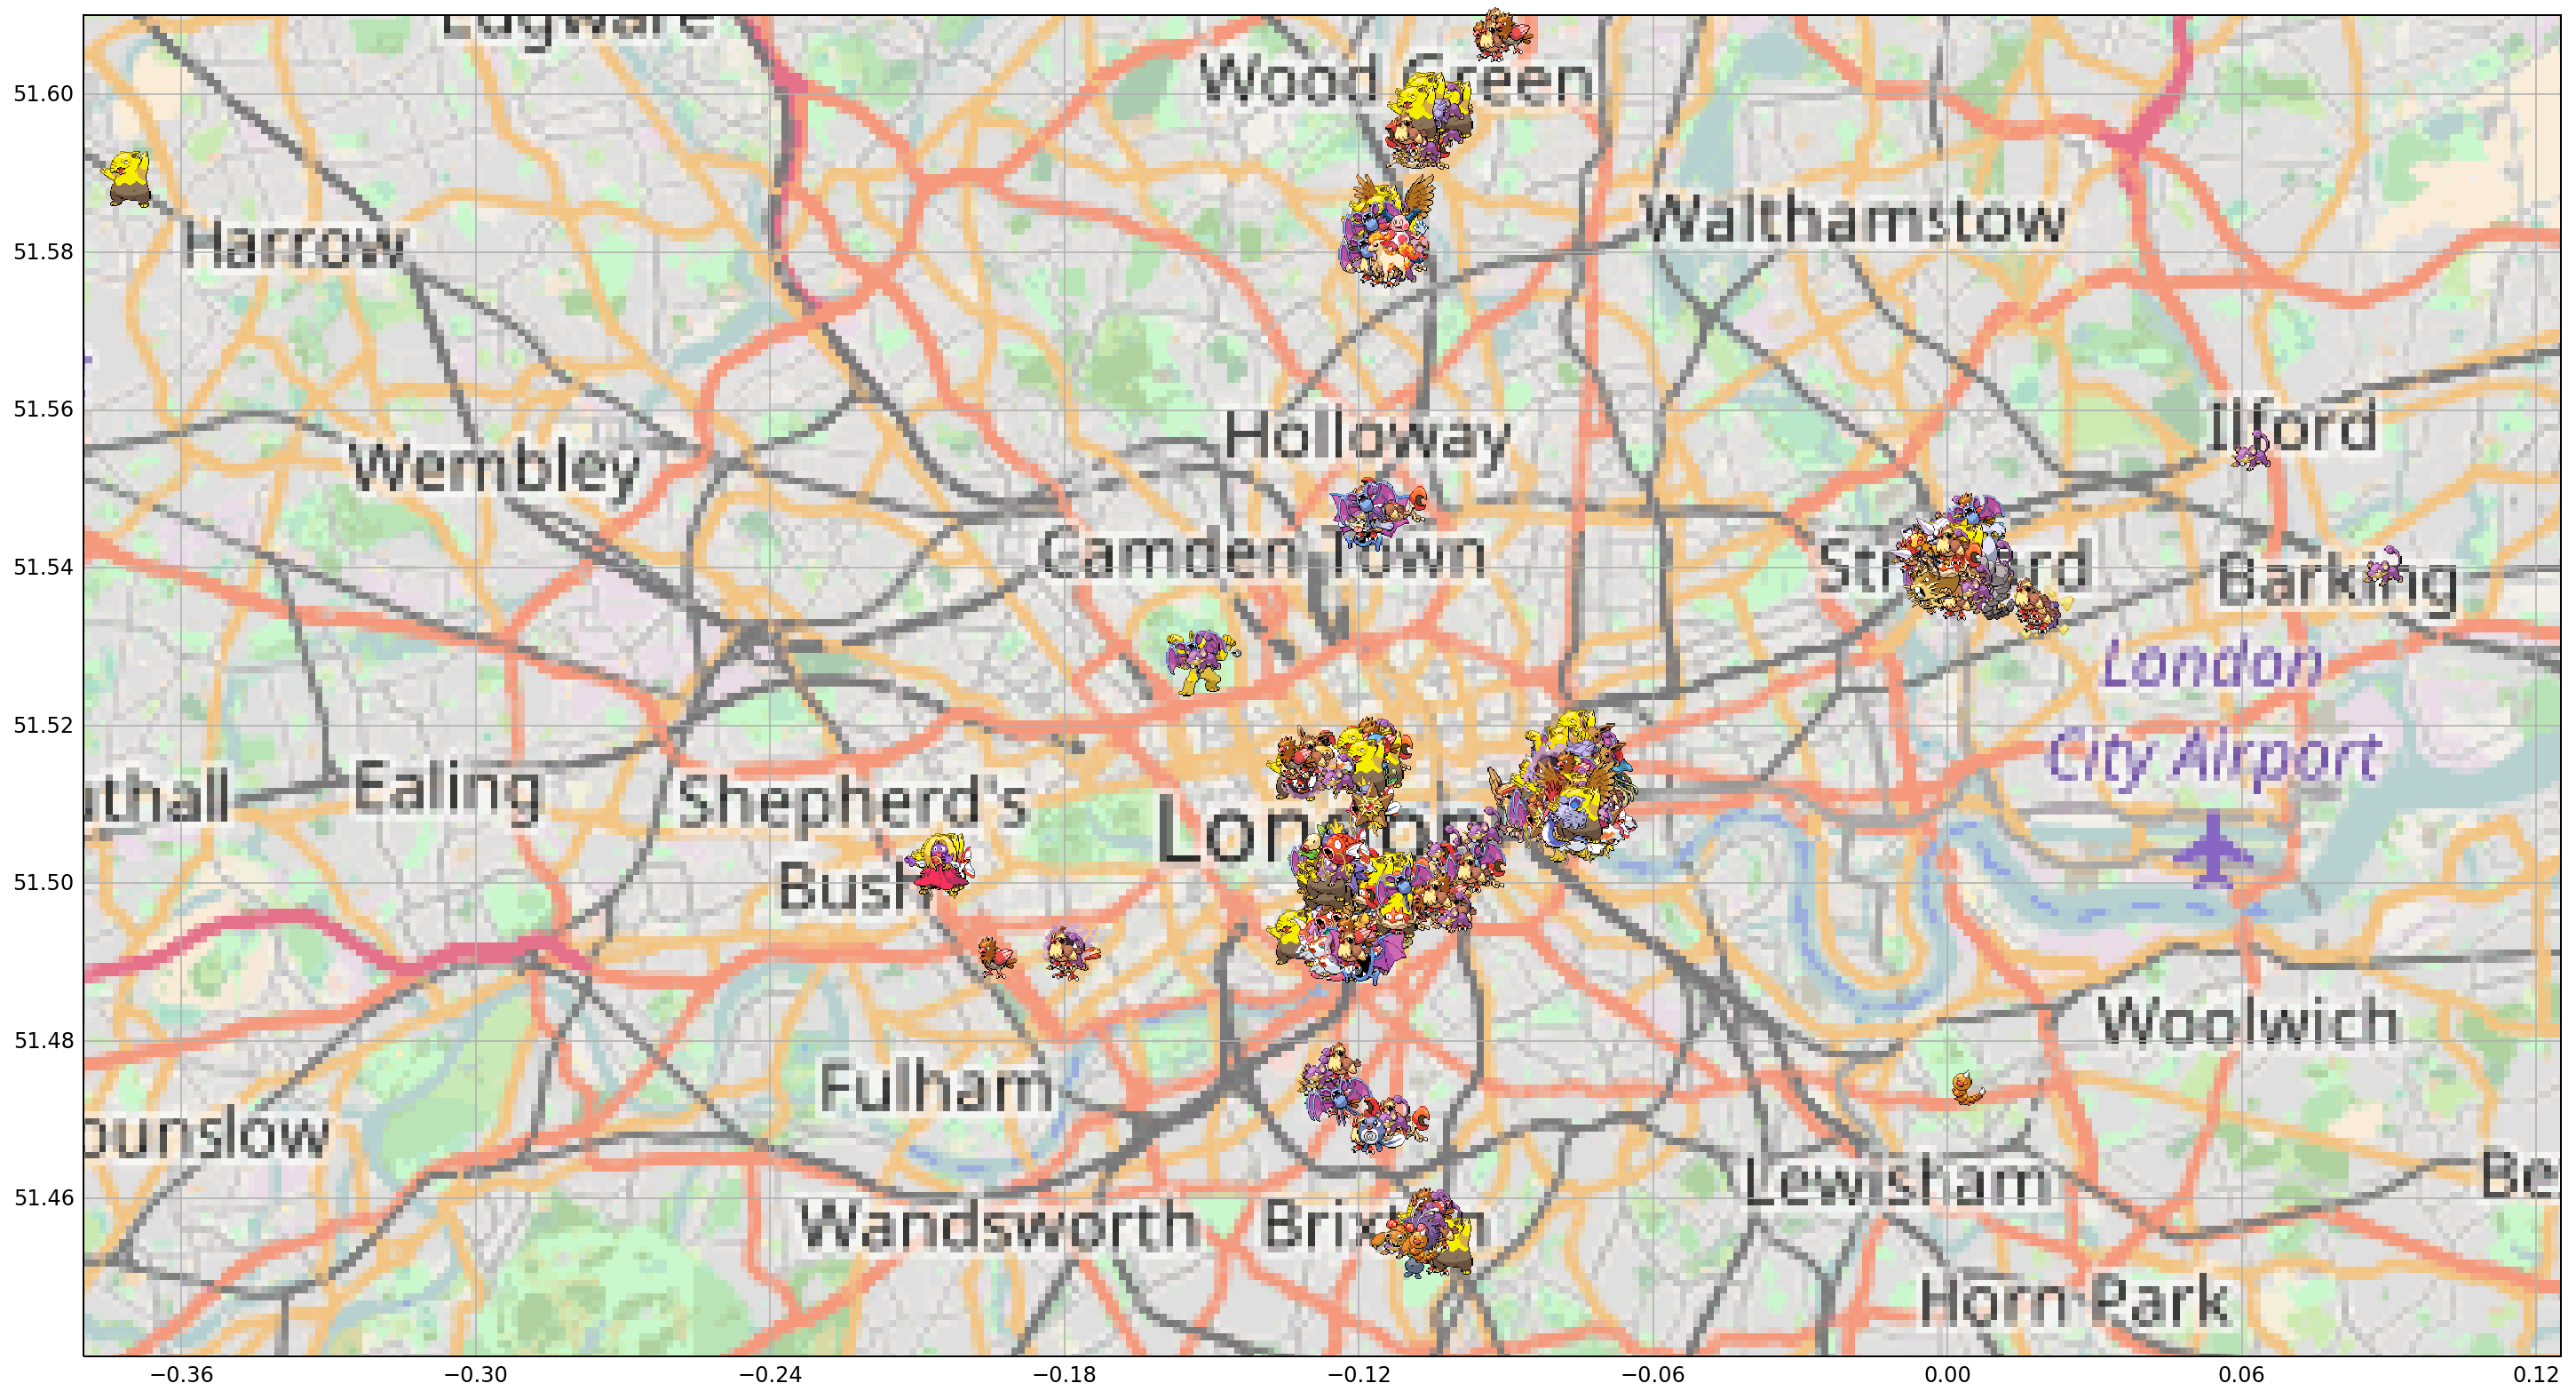

In [50]:
extent = (-0.38, 0.125, 51.44, 51.61)
detail_level = 10 
plot_pokemons(df2, extent, detail_level)

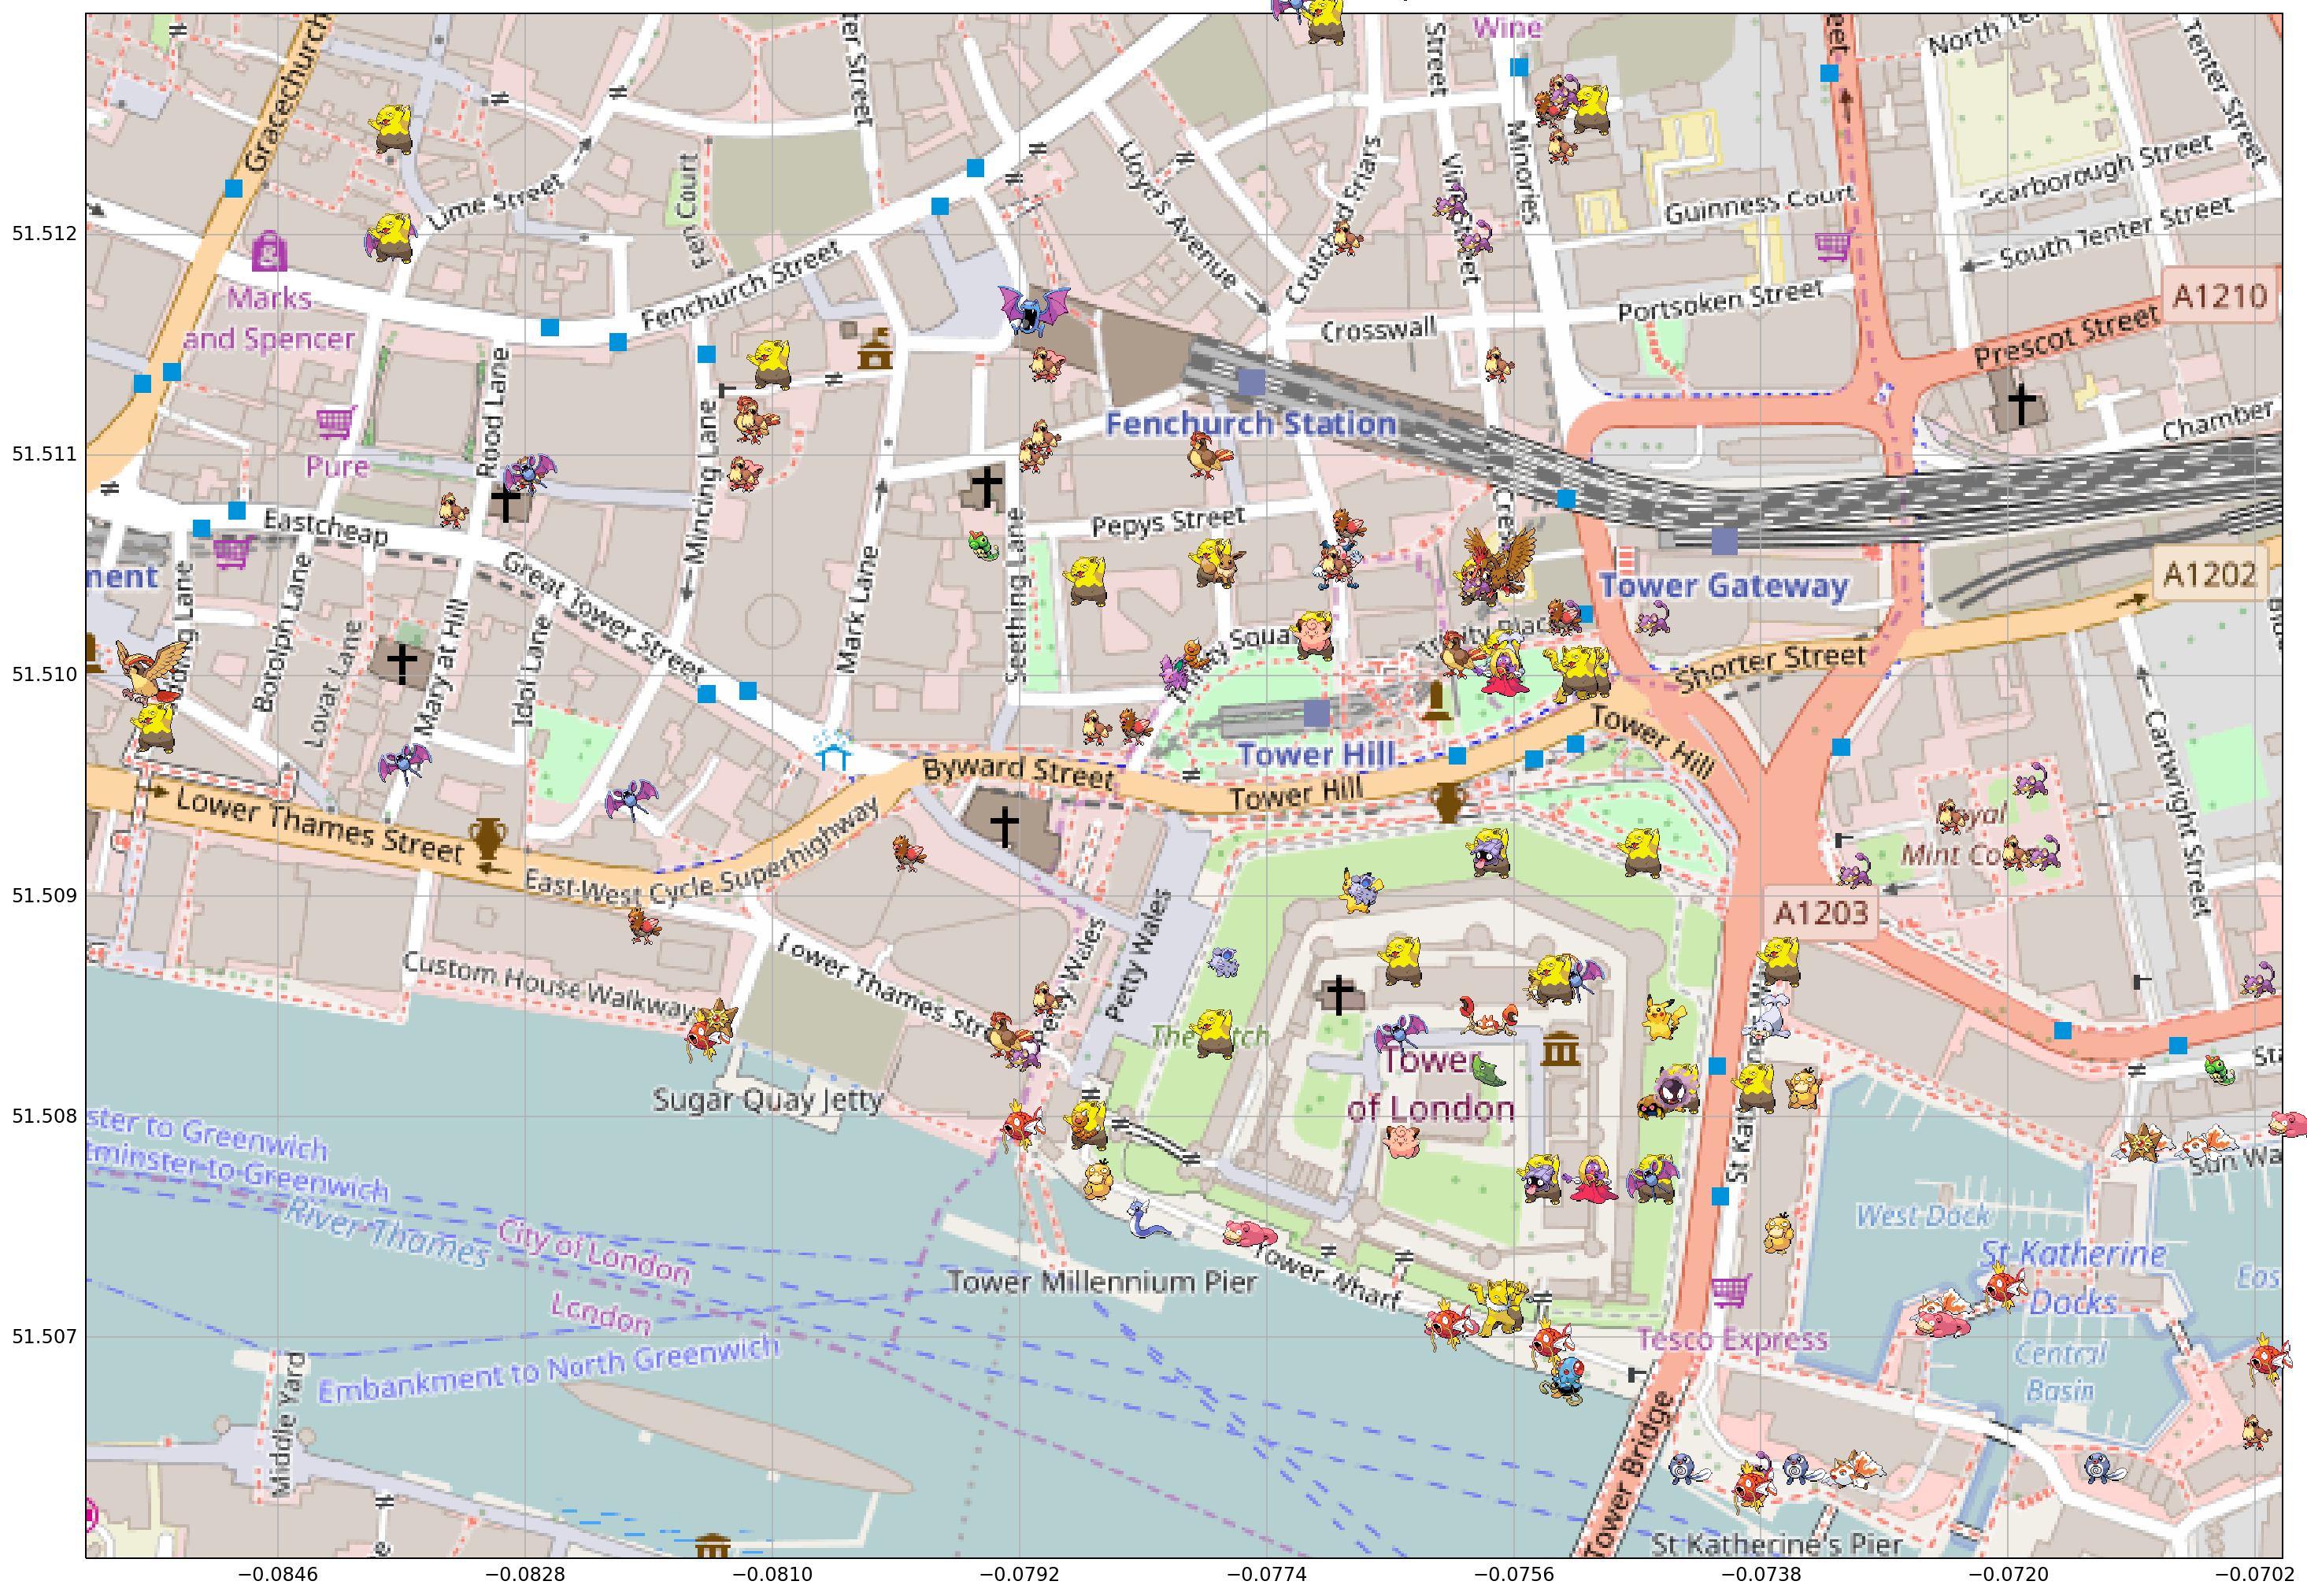

In [54]:
extent = (-0.086, -0.07, 51.506, 51.513) # tower of london 
detail_level = 16
plot_pokemons(df2, extent, detail_level)

### Exercise 2

Unfortunately there are no pokemon sightings in the dataset around the Austin AT&T Convention center and the Texas Capitol (none in Austin at all...)

Plot the Pokemons in Central Park, NY.

Tip: get coordinates from Google Maps: https://support.google.com/maps/answer/18539

In [55]:
#
#
# SOLUTION STARTS HERE
#
#

In [61]:
central_park_coords = "(latitude > 40.764) & (latitude < 40.786) & (longitude > -73.982) & (longitude < -73.96)"

In [62]:
with pd.HDFStore(filename, mode='r') as hdf:    
    df2 = hdf.select(key='pokemons', where=central_park_coords)

In [63]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 9067 to 289092
Columns: 208 entries, pokemonId to target
dtypes: bool(168), float64(8), int64(17), object(8), uint64(7)
memory usage: 334.7+ KB


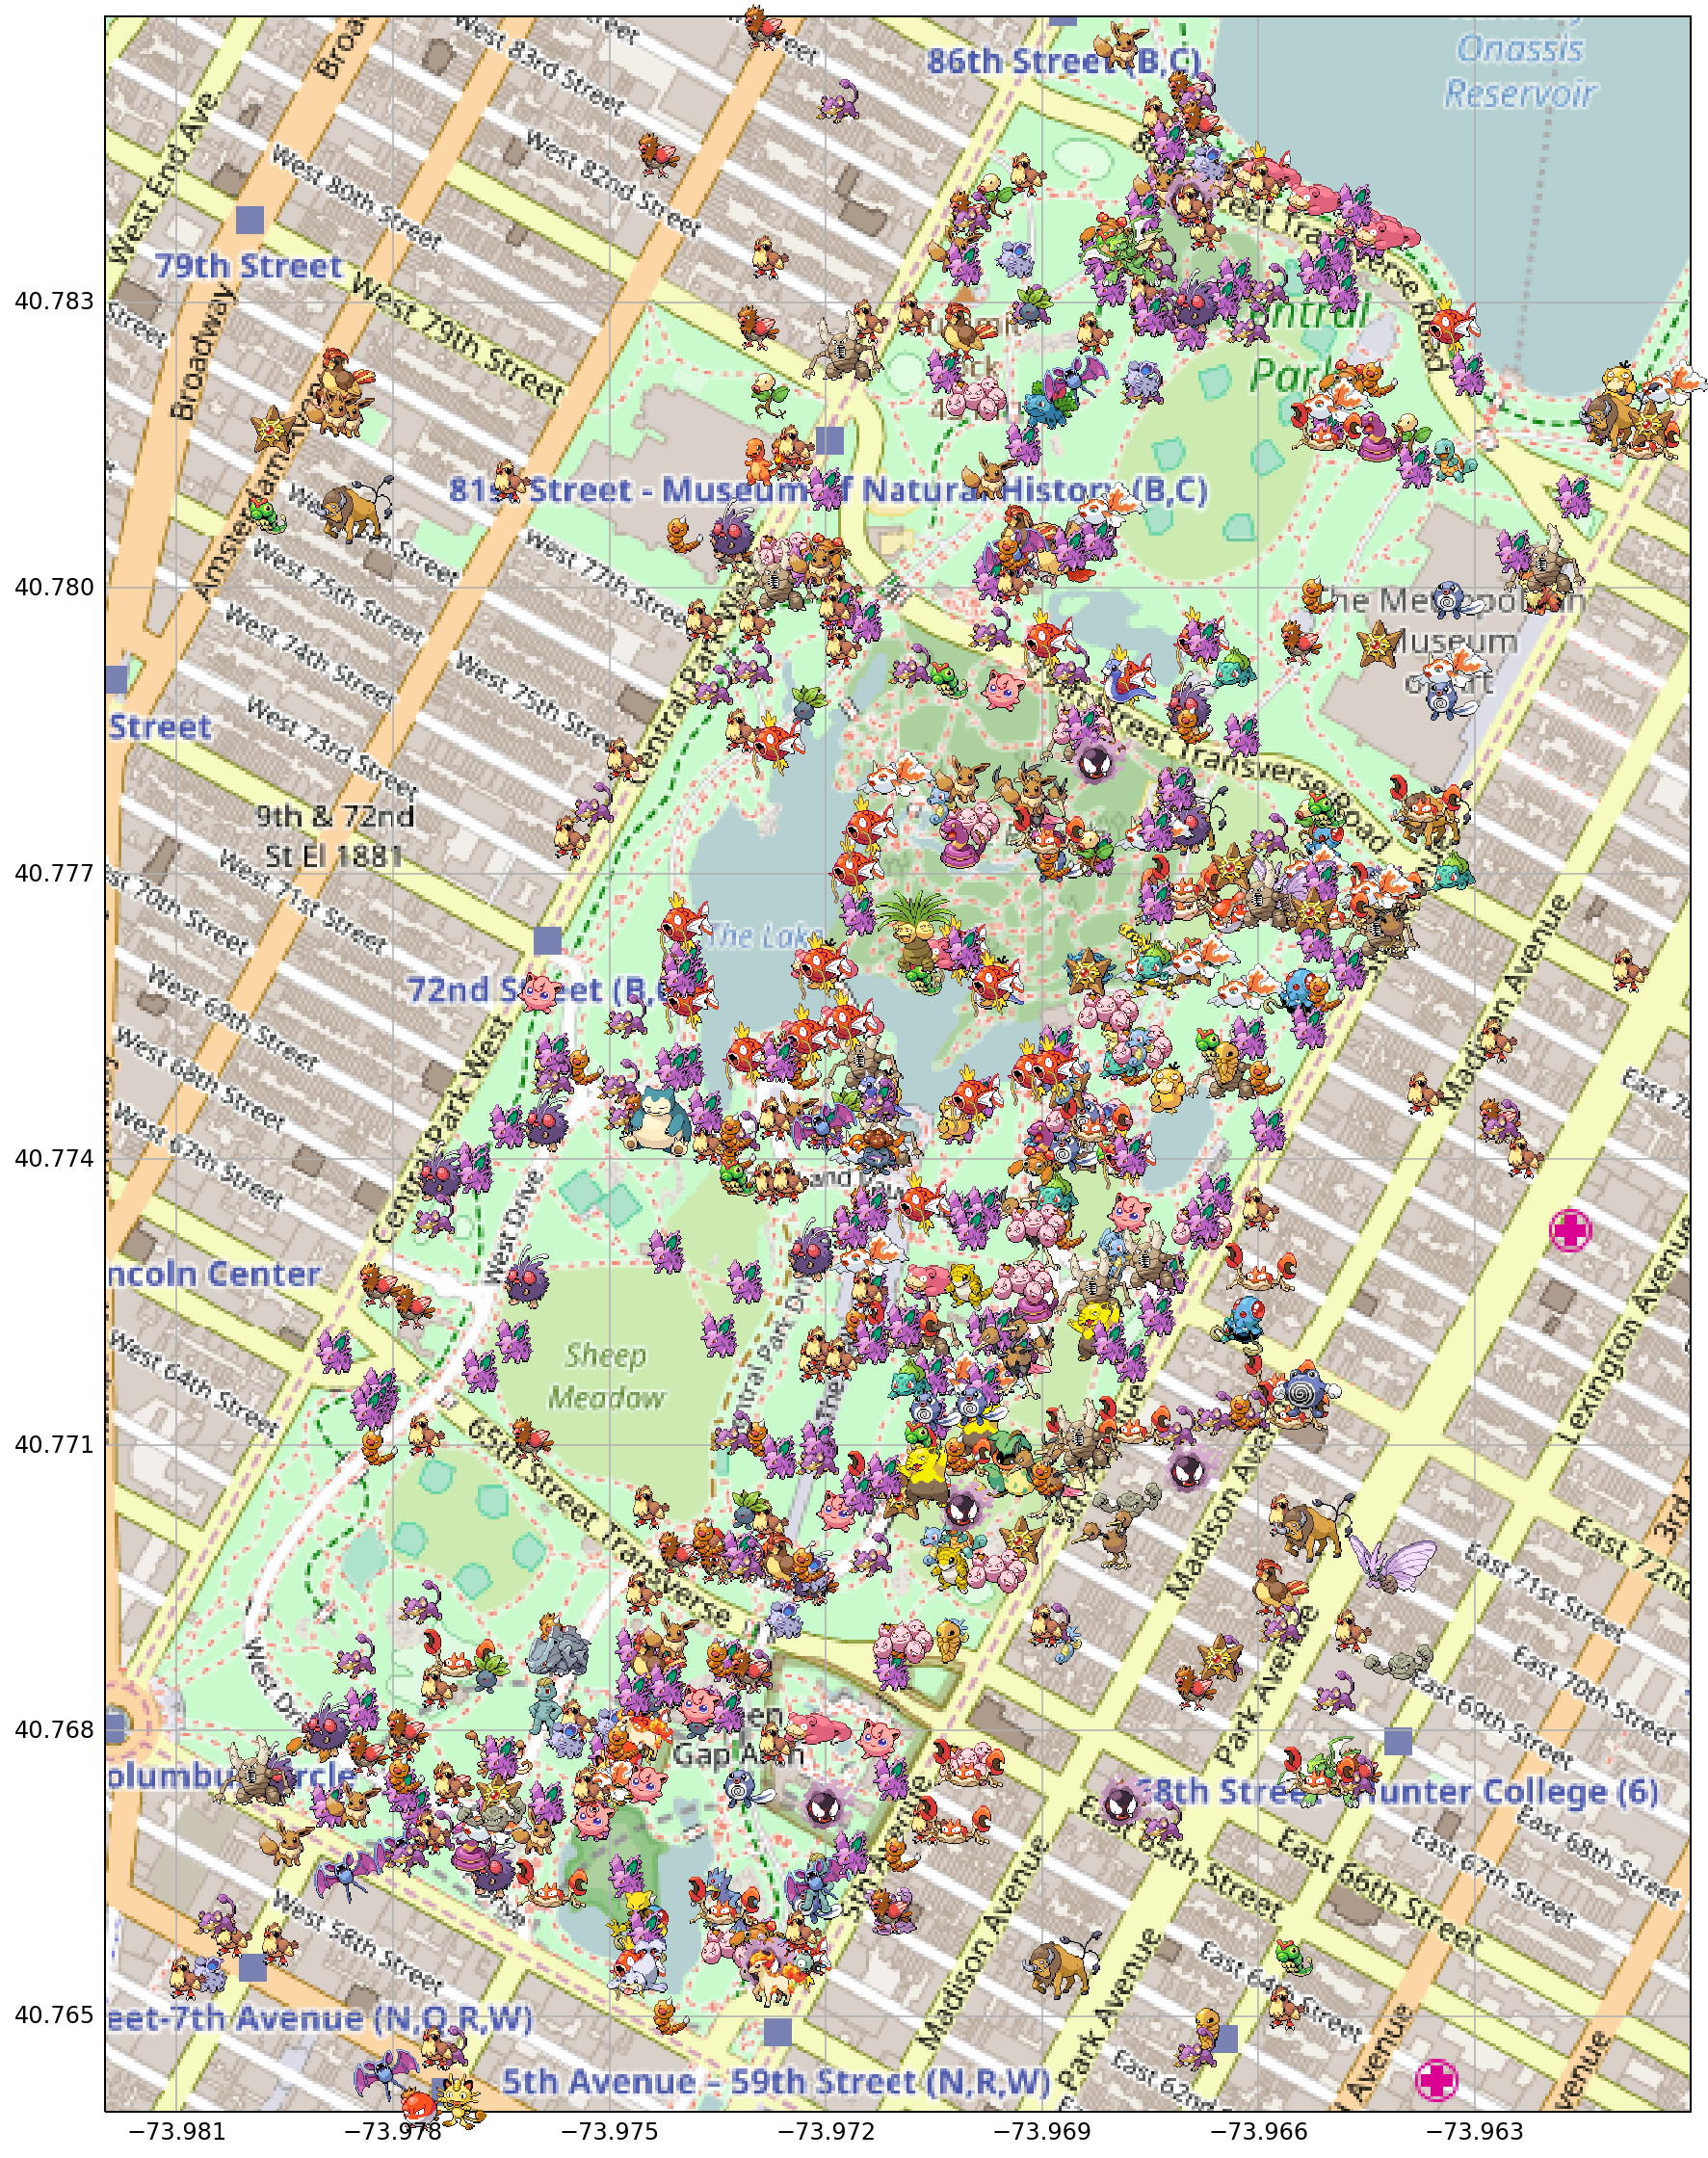

In [64]:
extent = (-73.982, -73.96, 40.764, 40.786)
detail_level = 15
plot_pokemons(df2, extent, detail_level)

### Exercise 3 (optional)

There are some pokemon which are exclusive of certain regions; these are Farfetch'd (**target**=83), Kangashkan (**target**=115), Mr. Mime (**target**=122) and Tauros (**target**=128).  Plot the world map with only these pokemon.  

**Tip**: for plotting a world-wide view, copy the `plot_pokemons` function and replace the following lines: 

```python
tiler = cimgt.OSM()
fig, ax = plt.subplots(figsize=(25, 20), 
                       subplot_kw=dict(projection=tiler.crs))
# Grid and limits
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
ax.set_extent(extent)
# Tiler image and detail level
ax.add_image(tiler, detail_level) # always use low detail level during exploration
```

by

```python
fig, ax = fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=ccrs.Mollweide()))
ax.stock_img()
```


In [65]:
#
#
# Solution starts here
#
#

In [66]:
with pd.HDFStore(filename, mode='r') as hdf: 
    df2 = hdf.select(key='pokemons', where='target=[122,128,115,83]')

In [69]:
def plot_pokemons(df, extent=None, detail_level=1, world_mode=False):
    
    if world_mode:
        fig, ax = fig, ax = plt.subplots(figsize=(25, 20), 
                           subplot_kw=dict(projection=ccrs.Mollweide()))
        ax.stock_img()
    else:
        tiler = cimgt.OSM()
        fig, ax = plt.subplots(figsize=(25, 20), 
                               subplot_kw=dict(projection=tiler.crs))
        # Grid and limits
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        ax.set_extent(extent)
        # Tiler image and detail level
        ax.add_image(tiler, detail_level) # always use low detail level during exploration
    # Point transformation from cartopy to matplotlib
    crs = ccrs.Geodetic()
    transform = crs._as_mpl_transform(ax)
    # Mapping points to Pokemon sprites
    x, y, targets = df.longitude.values, df.latitude.values, df.target.values
    artists = []
    for i in range(len(df)):
        image = plt.imread('datasets/pokemon/sprites/' + str(targets[i]) + '.png')
        im = OffsetImage(image, zoom=0.6)
        ab = AnnotationBbox(im, (x[i], y[i]), xycoords=transform, frameon=False)
        artists.append(ax.add_artist(ab))
    ax.plot(x, y, 'ob')

    plt.show()

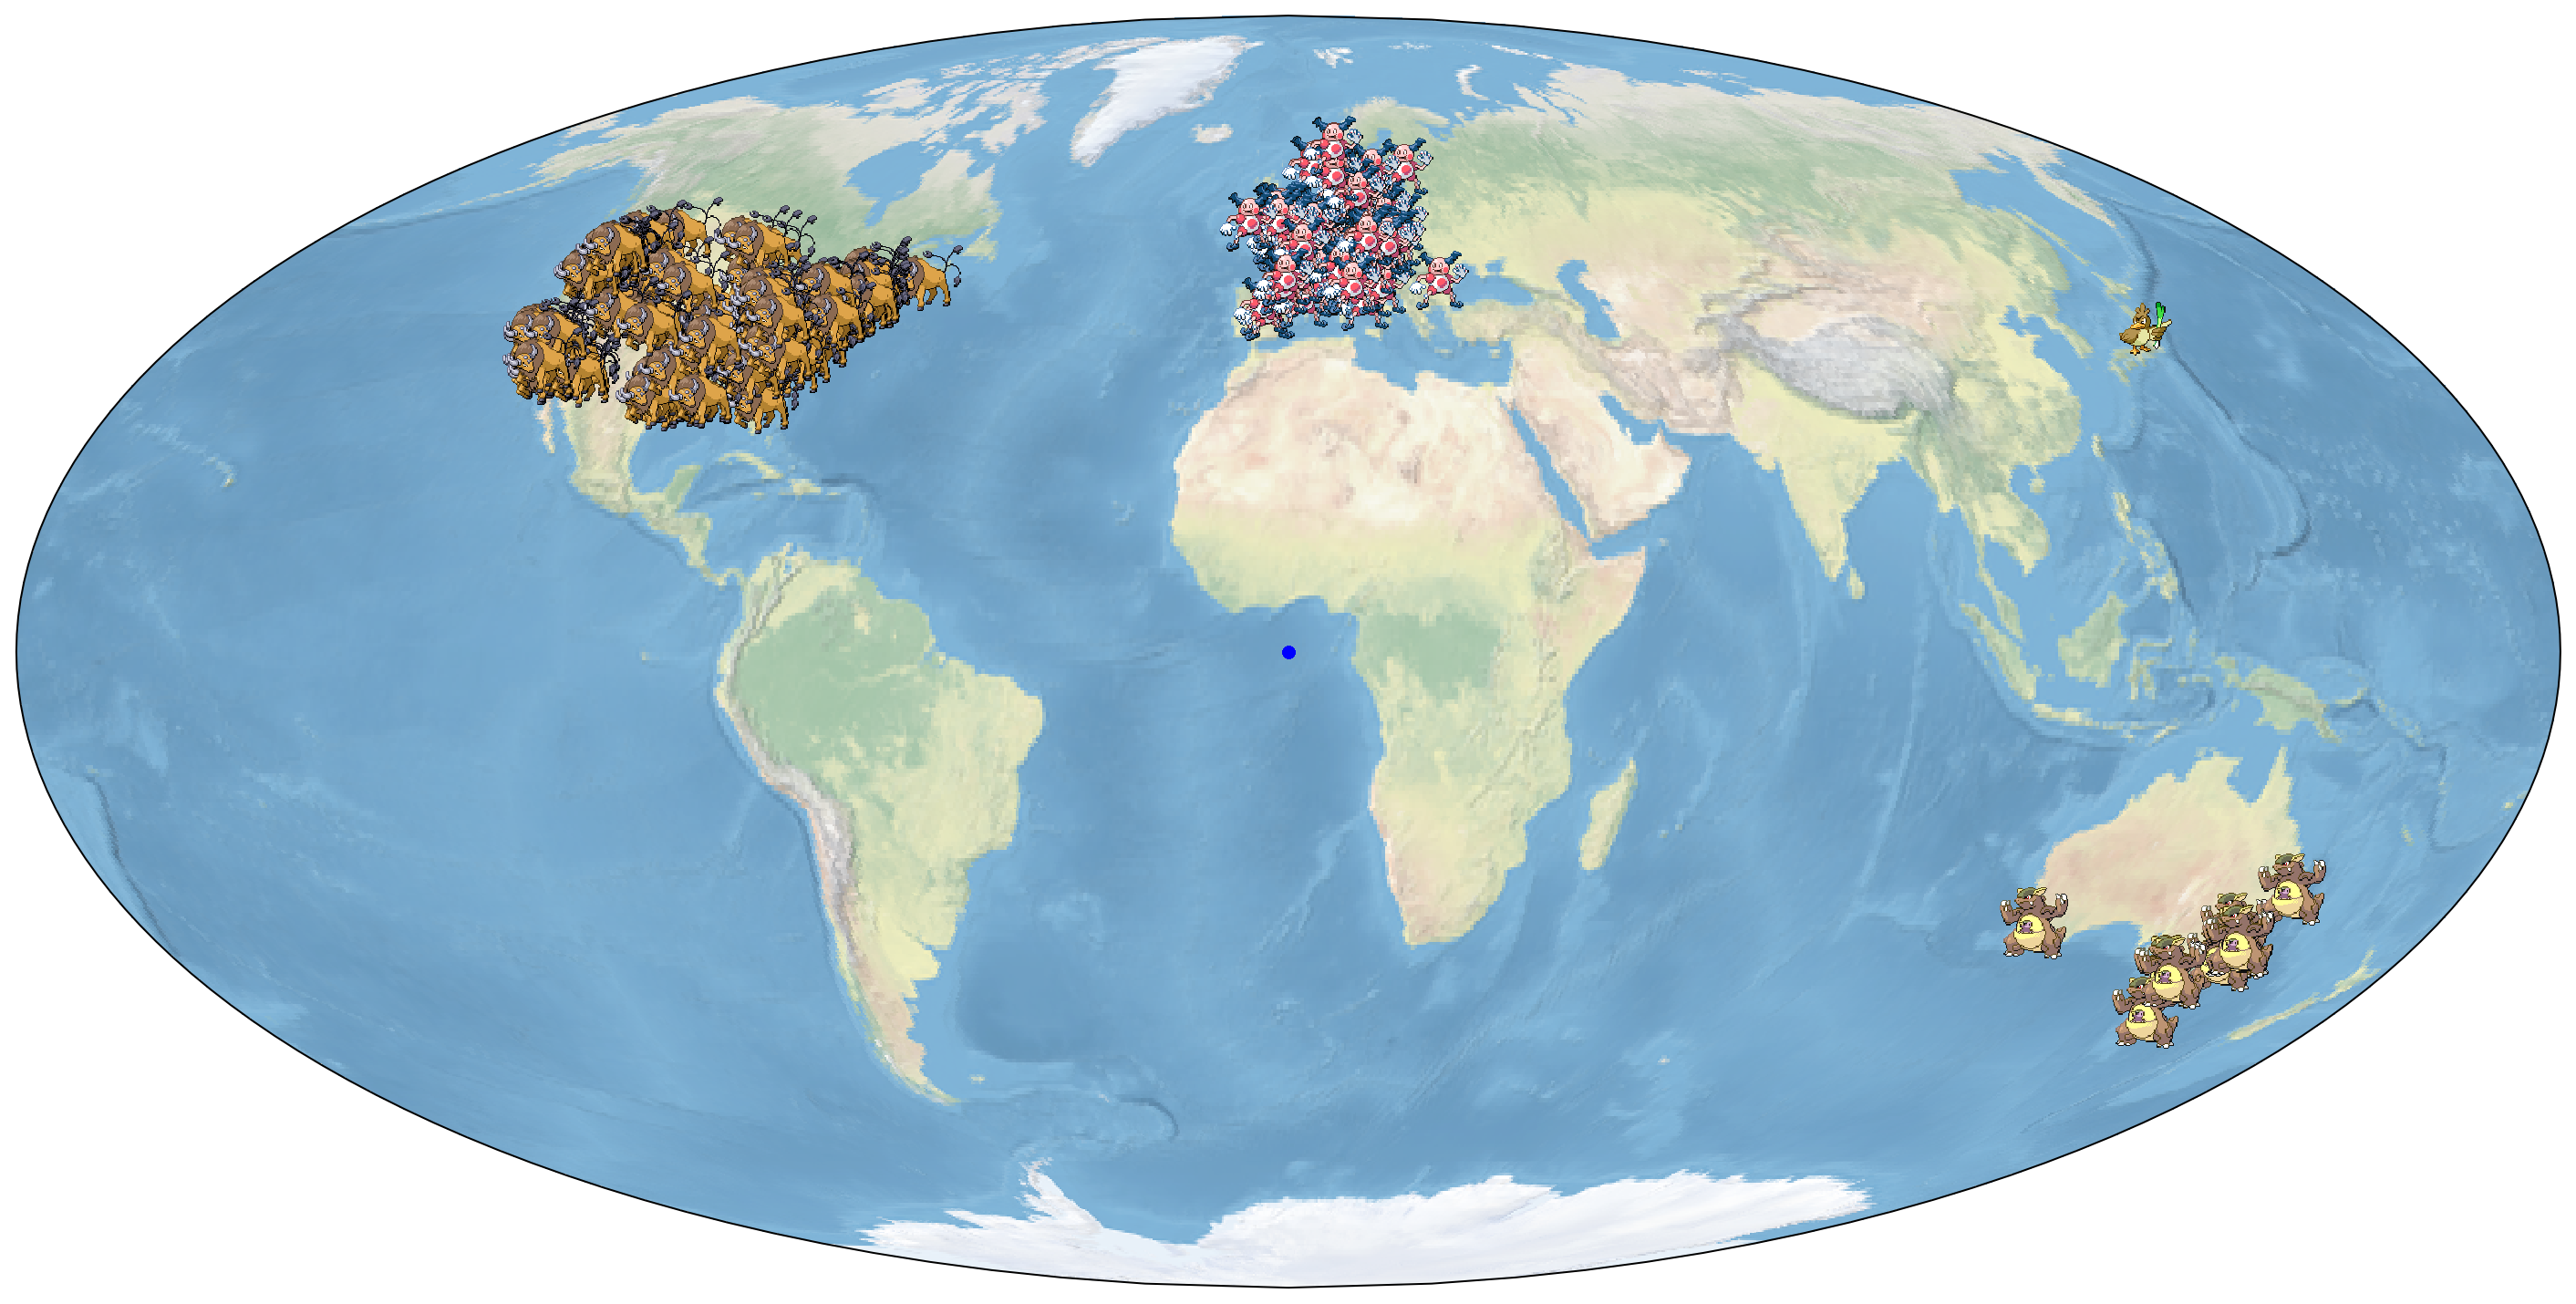

In [70]:
plot_pokemons(df2, world_mode=True)

# Exercise 4

Let's revisit the UFO sightings dataset: `datasets/ufo_scrubbed.csv`.

Use `pandas` to store it into an HDF5 file. Use the hierarchy to split the dataset as we did before. (Geospatial for example).


In [5]:
df = pd.read_csv('datasets/ufo_scrubbed.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
datetime                80332 non-null object
city                    80332 non-null object
state                   74535 non-null object
country                 70662 non-null object
shape                   78400 non-null object
duration (seconds)      80332 non-null float64
duration (hours/min)    80332 non-null object
comments                80317 non-null object
date posted             80332 non-null object
latitude                80332 non-null float64
longitude               80332 non-null float64
dtypes: float64(3), object(8)
memory usage: 6.7+ MB


In [7]:
df.head()

datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3  10/10/1956 21:00                  edna    tx      us    circle   
4  10/10/1960 20:00               kaneohe    hi      us     light   

   duration (seconds) duration (hours/min)  \
0              2700.0           45 minutes   
1              7200.0              1-2 hrs   
2                20.0           20 seconds   
3                20.0             1/2 hour   
4               900.0           15 minutes   

                                            comments date posted   latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.883056   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005  29.384210   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008  53.200000   
3  My older brother and twin sister were leaving ...   1/17/2004  28.978333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...   1/22/2004  21.418056   

    longitude  
0  -97.941111  
1  -98.581082  
2   -2.916667  
3  -96.645833  
4 -157.803611

We can select a portion of the dataframe (in pandas, in memory) by using `df.query`:

In [8]:
df2 = df.query('country=="us"')

And we can select (filter) columns by using `df[['col1', 'col2', ...]]`:

In [12]:
df2[['city', 'state']].head(5)

city state
0  san marcos    tx
3        edna    tx
4     kaneohe    hi
5     bristol    tn
7     norwalk    ct

In [13]:
#
#
# SOLUTION STARTS HERE
#
#
